### Simple CNN Image Classification
이번 실습에서는 tensorflow library를 이용하여 간단한 CNN 구조를 생성하고 CIFAR-10 dataset을 학습하여 성능을 평가한다.

In [1]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

# pylint: disable=missing-docstring
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (10,10)

sys.path.append(os.path.join(os.getcwd(), '..'))
from cifar10_loader import CIFAR10_loader
from utils import *

### Download the CIFAR-10 dataset
**CIFAR-10** dataset은 32x32 사이즈의 이미지들로 airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck으로 이루어져있다. 각 클래스 별 6천장씩 구성되어 있으며 이중 50000장이 training에 사용되고 10000장이 test에 사용된다. TF-Slim library에서 제공하는 코드를 이용하여 현재 작업중인 폴더의 하위 폴더에 cifar-10 dataset을 저장한다.

*CIFAR datasets URL*: https://www.cs.toronto.edu/~kriz/cifar.html

*CIFAR-10 download link*: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [2]:
# data_dir = 'cifar10_data'
# data_url = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
# maybe_download_and_extract(data_url, data_dir, 'cifar-10-batches')

### Create data loader and check the CIFAR-10 dataset
위에서 다운받은 데이터를 batch 단위로 읽어올 수 있는 data loader class를 선언. 현재 data loader는 get_batch()를 통해 단순히 이미지 및 레이블을 batch 크기만큼 받아올 수 있으며, 여기서는 특별한 preprocessing을 하지는 않는다. 하지만 보통 더 높은 성능을 위해서 random crop, flipping 등의 preprocessing을 하는 편이다.

In [3]:
loader = CIFAR10_loader()
class_names = loader.get_class_names()

/home/pirl/anaconda3/envs/edu/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


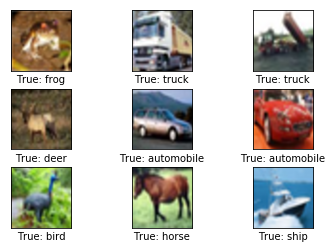

In [4]:
batch = loader.get_batch(9)
fig = plot_images(batch['images'], batch['labels'], class_names)
fig.show()

### Functions for constructing model (graph)
Object classification을 위한 convolutional 네트워크를 선언하자. 네트워크를 선언하는 코딩 스타일은 사람마다 다르나 보통 아래와 같이 5부분 (input, model, loss, optimizer, accuracy)으로 나눠서 선언하는 경우가 많다. 
 - build_model(): 네트워크의 실제 연산을 담당하는 부분으로 2개의 convolutional layer 및 2개의 fully connected layer와 classification layer로 구성된다.
 - build_loss(): 학습을 위한 loss를 정의하며 여기에서는 cross-entropy loss를 사용한다.
 - build_train_operation(): 학습을 위한 파라미터들의 gradient 계산 및 파라미터 업데이트를 하는 optimizer를 정의. 여기에서는 Adam optimizer를 사용한다.
 - build_accuracy(): 테스트를 위하여 accuracry를 정의.
 
 tensorflow python api page: https://www.tensorflow.org/api_docs/
 

### Tensorflow Initializer
- tf.constant_initializer()
- tf.truncated_normal_initializer()
- tf.random.uniform_initializer()

tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32)
- range W = [-sqrt(6 / (in + out), sqrt(6 / (in + out)] (for uniform)
- range W = [-sqrt(3 / (in + out), sqrt(3 / (in + out)] (for normal)

#### Practice
xavier initializer로 바꿔서 weight을 초기화 하시오.

In [5]:
loader.reset() # set iterator as 0

# Get variable initialization function
initializer = tf.truncated_normal_initializer(stddev=0.01, dtype=tf.float32)

In [6]:
def build_inputs(batch_size, image_size):
    """ Construct input for CIFAR evaluation using the Reader ops.
    Args:
        batch_size: Batch size.
        image_size: Image size.
    Returns:
        images: Images. 4D tensor of [batch_size, IMAGE_SIZE, IMAGE_SIZE, 3] size.
        labels: Labels. 1D tensor of [batch_size] size.
    """
    with tf.variable_scope('inputs') as scope:
        images = tf.placeholder(dtype=tf.float32, shape=[batch_size, image_size, image_size, 3],
                               name='images')
        labels = tf.placeholder(dtype=tf.int64, shape=[batch_size], name='labels')
    
    return images, labels

### Tensorflow layers
https://www.tensorflow.org/api_guides/python/contrib.layers

- tf.contrib.layers.conv2d()
- tf.contrib.layers.max_pool2d
- tf.contrib.layers.flatten()
- tf.contrib.layers.fully_connected()
- tf.contrib.layers.dropout()

#### Practice
CNN 구조를 ppt에 나온 구조로 바꿔서 학습하시오.

- conv3x3 32
- conv3x3 32
- maxpool
- conv3x3 64
- conv3x3 64
- maxpool
- FC-512
- FC-512

In [7]:

def build_model(images):
    """ Build the CIFAR-10 model consists of 2 convolutional, 2 fully connected and
    1 classification layer.
    Args:
        images: Images returned from build_inputs(). 4-D tensor.
    Returns:
        Logits.
    """
    
    # conv1
    conv1     = tf.contrib.layers.conv2d(images, 64, [3, 3], padding='SAME', activation_fn=tf.nn.relu, weights_initializer=initializer, scope='conv1')
    # pool1
    max_pool1 = tf.contrib.layers.max_pool2d(conv1, [2, 2], padding='VALID', scope='pool1')
    # conv2
    conv2     = tf.contrib.layers.conv2d(max_pool1, 64, [3, 3], padding='SAME', 
                                         activation_fn=tf.nn.relu, weights_initializer=initializer, scope='conv2')
    # pool2
    max_pool2 = tf.contrib.layers.max_pool2d(conv2, [2, 2], padding='VALID', scope='pool2')
    
    flat = tf.contrib.layers.flatten(max_pool2)
    
    # fc1
    fc1 = tf.contrib.layers.fully_connected(flat, 384, activation_fn=tf.nn.relu, weights_initializer=initializer, scope='fc1')
    fc1_dropout = tf.contrib.layers.dropout(fc1, 0.5, is_training=True, scope='dropout1')
    # fc2
    fc2 = tf.contrib.layers.fully_connected(fc1_dropout, 192, activation_fn=tf.nn.relu, weights_initializer=initializer, scope='fc2')
    fc2_dropout = tf.contrib.layers.dropout(fc2, 0.5, is_training=True, scope='dropout2')
    # fc3
    logits = tf.contrib.layers.fully_connected(fc2_dropout, loader.get_num_classes(), activation_fn=None, normalizer_fn=None, scope='fc3')
        
    return logits

### Tensorflow losses
https://www.tensorflow.org/api_docs/python/tf/nn

cross entropy loss with softmax is best

In [8]:
def build_loss(logits, labels):
    """ Add L2Loss to all the trainable variables.
    Add summary for "Loss" and "Loss/avg".
    Args:
        logits: Logits from build_model().
        labels: Labels from build_inputs(). 1-D tensor.
    Returns:
        Loss tensor of type float.
    """
    # Calculate the average cross entropy loss across the batch.
    labels = tf.cast(labels, tf.int64) # casting tensor 
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=labels, logits=logits, name='cross_entropy_per_example')
    cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')
    #tf.add_to_collection('losses', cross_entropy_mean)

    # The total loss is defined as the cross entropy loss plus all 
    # of the weight decay terms (L2 loss).
    #return tf.add_n(tf.get_collection('losses'), name='total_loss')
    return cross_entropy_mean

### Tensorflow traning
Gradient optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

- tf.train.GradientDescentOptimizer()
- tf.train.AdamOptimizer()
- tf.train.MomentumOptimizer()

In [9]:
def build_train_operation(total_loss):
    """ Train CIFAR-10 model and create an optimizer.
    Args:
        total_loss: Total loss from build_loss().
        
    Returns:
        train_op: op for training.
        global_step: global step counting iteration
    """
    global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)
    #learning_rate = 0.0001
    
    lr = tf.train.exponential_decay(
    learning_rate = 0.001,
    global_step = global_step,
    decay_steps = 10000,
    decay_rate = 0.9,
    staircase = True)
    
    # Create the optimizer which will minimize the loss.
    # Below two methods are equivalent. But, when you want to process
    # the gradients before updating a model, second method is appropriate.
    #train_op = tf.train.AdamOptimizer(learning_rate).minimize(total_loss, global_step=global_step)
    train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(total_loss, global_step=global_step)
    return train_op, global_step

def build_accuracy(logits, labels):
    """ Accuarcy computed by
        accuracy = # of correct examples / # of total examples
    Args:
        logits: Logits from build_model().
        labels: Labels from build_model().
    Returns:
        accuracy: Accuracy.
        correct_num: The number of corrected examples
        pred_labels: Predicted labels by the model
    """
    pred_labels = tf.argmax(logits, axis=1)
    correct_prediction = tf.equal(pred_labels, tf.cast(labels, tf.int64))
    correct_num = tf.reduce_sum(tf.cast(correct_prediction, tf.float32))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return accuracy, correct_num, pred_labels

### Training the model

모델 학습을 위한 파라미터 정의

In [10]:
# Model parameters
batch_size = 100
num_epochs = 50
iteration_per_epoch = int(math.floor(loader.get_num_train_examples() / batch_size))
save_checkpoint_frequency = 500
print_frequency = 100

모델 정의

In [11]:
"""Train CIFAR-10 for a number of steps."""
tf.reset_default_graph()

# build input placeholders
images, labels = build_inputs(batch_size, loader.get_image_size())

# Build a Graph that computes the logits predictions from the
# inference model.
logits = build_model(images)

# Calculate loss.
loss = build_loss(logits, labels)

# Build a Graph that trains the model with one batch of examples and
# updates the model parameters.
train_op, global_step = build_train_operation(loss)

# Build the accuracy and correct number of examples
# to check model is learned correctly while training
accuracy, correct_num, prediction = build_accuracy(logits, labels)

모델을 실행 할 session을 생성 및 모델의 weight를 초기화

In [12]:
# Open the session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

정의한 모델을 구성하는 layer 및 그 name을 확인하는 방법을 알아보자. 또한, 특정 variable을 얻고 그 값을 확인하는 방법을 알아보자.

In [13]:
print('The list of variables (or layers) in the model:')
for var in tf.global_variables():
    print(var)
    #print(var.op.name)

The list of variables (or layers) in the model:
<tf.Variable 'conv1/weights:0' shape=(3, 3, 3, 64) dtype=float32_ref>
<tf.Variable 'conv1/biases:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'conv2/weights:0' shape=(3, 3, 64, 64) dtype=float32_ref>
<tf.Variable 'conv2/biases:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'fc1/weights:0' shape=(4096, 384) dtype=float32_ref>
<tf.Variable 'fc1/biases:0' shape=(384,) dtype=float32_ref>
<tf.Variable 'fc2/weights:0' shape=(384, 192) dtype=float32_ref>
<tf.Variable 'fc2/biases:0' shape=(192,) dtype=float32_ref>
<tf.Variable 'fc3/weights:0' shape=(192, 10) dtype=float32_ref>
<tf.Variable 'fc3/biases:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'global_step:0' shape=() dtype=int32_ref>
<tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>
<tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>
<tf.Variable 'conv1/weights/Adam:0' shape=(3, 3, 3, 64) dtype=float32_ref>
<tf.Variable 'conv1/weights/Adam_1:0' shape=(3, 3, 3, 64) dtype=float32

중간 레이어 결과값 혹은 사이즈 확인

In [14]:
cc = sess.run('conv1/weights:0', feed_dict={images:loader.get_batch(batch_size, 'train')['images']})
print(cc.shape)

(3, 3, 3, 64)


In [15]:
cc = sess.run('fc1/weights:0', feed_dict={images:loader.get_batch(batch_size, 'train')['images']})
print(cc.shape)

(4096, 384)


모델의 파라미터 확인

In [16]:
logit_weight = tf.get_default_graph().get_tensor_by_name('fc3/weights:0')
logit = logit_weight.eval(session=sess)
print(logit.shape)
print(logit[0,:10])
print(sess.run(logit_weight)[0,:10])

(192, 10)
[-0.00727998 -0.06647579  0.01235329  0.09874626 -0.11533862 -0.02141429
  0.10647531  0.0707307  -0.11761054  0.14996739]
[-0.00727998 -0.06647579  0.01235329  0.09874626 -0.11533862 -0.02141429
  0.10647531  0.0707307  -0.11761054  0.14996739]


모델 학습

In [17]:
## Model parameters
save_path = 'cifar10_ramdom-init_checkpoints/cifar10_cnn'
if not os.path.exists('cifar10_ramdom-init_checkpoints'): 
    os.makedirs('cifar10_ramdom-init_checkpoints')
    
# Train the model
saver = tf.train.Saver()

# Train the model
for ie in range(num_epochs):
    for ii in range(iteration_per_epoch):
        # Load a batch data
        batch = loader.get_batch(batch_size, 'train')

        # Run the optimizer
        iteration, _ = sess.run([global_step, train_op], 
                                             feed_dict={images:batch['images'],
                                                        labels:batch['labels']})

        # Print the accuracy and loss of current batch data
        if iteration % print_frequency == 0:
            batch_loss, batch_acc = sess.run([loss, accuracy], 
                                             feed_dict={images:batch['images'],
                                                        labels:batch['labels']})
            print('%d Epoch %d iteration - Loss (%.3f) Accuracy (%.3f)' 
                      %(ie+1, ii+1, batch_loss, batch_acc))
            
        # Save checkpoint
        if (ii+1) % save_checkpoint_frequency == 0:
            saver.save(sess, save_path=save_path, global_step=ie*iteration_per_epoch + ii + 1)
            print('Saved checkpoint %s_%d' % (save_path, ie*iteration_per_epoch + ii + 1))

sess.close()

1 Epoch 100 iteration - Loss (2.112) Accuracy (0.220)
1 Epoch 200 iteration - Loss (1.926) Accuracy (0.260)
1 Epoch 300 iteration - Loss (1.915) Accuracy (0.330)
1 Epoch 400 iteration - Loss (1.790) Accuracy (0.320)
1 Epoch 500 iteration - Loss (1.567) Accuracy (0.430)
Saved checkpoint cifar10_ramdom-init_checkpoints/cifar10_cnn_500
2 Epoch 100 iteration - Loss (1.786) Accuracy (0.340)
2 Epoch 200 iteration - Loss (1.533) Accuracy (0.390)
2 Epoch 300 iteration - Loss (1.619) Accuracy (0.350)
2 Epoch 400 iteration - Loss (1.544) Accuracy (0.410)
2 Epoch 500 iteration - Loss (1.407) Accuracy (0.510)
Saved checkpoint cifar10_ramdom-init_checkpoints/cifar10_cnn_1000
3 Epoch 100 iteration - Loss (1.617) Accuracy (0.470)
3 Epoch 200 iteration - Loss (1.351) Accuracy (0.490)
3 Epoch 300 iteration - Loss (1.476) Accuracy (0.430)
3 Epoch 400 iteration - Loss (1.441) Accuracy (0.420)
3 Epoch 500 iteration - Loss (1.250) Accuracy (0.600)
Saved checkpoint cifar10_ramdom-init_checkpoints/cifar10_cn

### Evaluating the model


In [18]:
# Manually set the checkpoint path
#checkpoint_path = 'cifar10_checkpoints/cifar10_cnn-5000'
# Automatically find the last checkpoint
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir='cifar10_ramdom-init_checkpoints/')
print('Last checkpoint path is %s' % (checkpoint_path))

Last checkpoint path is cifar10_ramdom-init_checkpoints/cifar10_cnn-25000


In [19]:
#with tf.Session() as sess:
tf.reset_default_graph()

# Open the session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

"""Evaluation model"""
# build input placeholders
images, labels = build_inputs(batch_size, loader.get_image_size())

# Build a Graph that computes the logits predictions from the
# inference model.
logits = build_model(images)

# Calculate loss.
loss = build_loss(logits, labels)

# Build a Graph that trains the model with one batch of examples and
# updates the model parameters.
train_op, global_step = build_train_operation(loss)

# Build the accuracy and correct number of examples
# to check model is learned correctly while training
accuracy, correct_num, prediction = build_accuracy(logits, labels)

# Create Saver-object to save and reload the model later
saver = tf.train.Saver()
# Load the checkpoint or initialize the variables
if checkpoint_path != '':
    saver.restore(sess, save_path=checkpoint_path)
    print('Model is restored from %s' % checkpoint_path)
else:
    sess.run(tf.global_variables_initializer())

loader.reset()
num_correct = 0
num_examples = 0   

# Evaluate the model
while True:
    # Load a batch data
    batch = loader.get_batch(batch_size, 'test')
    if batch['wrapped']: break
    
    # Compute the correct numbers
    batch_acc, batch_correct_num = sess.run([accuracy, correct_num], 
                                            feed_dict={images:batch['images'],
                                                       labels:batch['labels']})

    num_correct += batch_correct_num
    num_examples += batch_size
    
print('Test accuracy: %.2f%%' % (float(num_correct) / float(num_examples) * 100.0))

sess.close()

INFO:tensorflow:Restoring parameters from cifar10_ramdom-init_checkpoints/cifar10_cnn-25000
Model is restored from cifar10_ramdom-init_checkpoints/cifar10_cnn-25000
Test accuracy: 63.22%


### Visualization
Plot the images and predicted & true labels

In [20]:
sess = tf.Session()
saver.restore(sess, save_path=checkpoint_path)

loader.reset()

INFO:tensorflow:Restoring parameters from cifar10_ramdom-init_checkpoints/cifar10_cnn-25000


/home/pirl/anaconda3/envs/edu/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


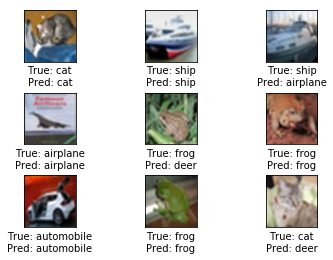

In [21]:
batch = loader.get_batch(batch_size, 'test')
realized_prediction = sess.run([prediction], feed_dict={images:batch['images'],labels:batch['labels']})
fig = plot_images(batch['images'][:9], batch['labels'][:9], loader.get_class_names(), realized_prediction[0][:9])
fig.show()

In [22]:
tf.reset_default_graph()
sess.close()